# Export LaMa inpainting model to ONNX


Author: [Nikita Selin](https://github.com/OPHoperHPO), [Carve.Photos Team](https://carve.photos) \
HuggingFace Repository with ONNX Model: [Link](https://huggingface.co/Carve/LaMa-ONNX) \
Original repository: [Link](https://github.com/advimman/lama)




## install deps

In [1]:
!git clone https://github.com/Carve-Photos/lama --depth 1

Cloning into 'lama'...
remote: Enumerating objects: 249, done.
remote: Counting objects: 100% (249/249), done.
remote: Compressing objects: 100% (193/193), done.
remote: Total 249 (delta 53), reused 133 (delta 48), pack-reused 0 (from 0)
Receiving objects: 100% (249/249), 5.68 MiB | 13.91 MiB/s, done.
Resolving deltas: 100% (53/53), done.


In [25]:
%cd /content/lama

/content/lama


In [3]:
!curl -LJO https://huggingface.co/smartywu/big-lama/resolve/main/big-lama.zip
!unzip big-lama.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1171  100  1171    0     0   4659      0 --:--:-- --:--:-- --:--:--  4646
100  363M  100  363M    0     0   115M      0  0:00:03  0:00:03 --:--:--  132M
Archive:  big-lama.zip
  inflating: big-lama/config.yaml    
  inflating: big-lama/models/best.ckpt  


In [7]:
!pip3 uninstall -y thinc
!pip3 install omegaconf webdataset pytorch_lightning pytorch_lightning kornia==0.5.0 onnx onnxruntime albumentations==0.5.2 "numpy<2.0.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.2/72.2 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 kB 19.0 MB/s eta 0:00:00
  Attempting uninstall: albumentations
    Found existing installation: albumentations 2.0.5
    Uninstalling albumentations-2.0.5:
      Successfully uninstalled albumentations-2.0.5


## init model

In [56]:
import torch
from omegaconf import OmegaConf
from yaml import safe_load

from saicinpainting.training.trainers.default import (
    DefaultInpaintingTrainingModule,
)


class ExportLama(torch.nn.Module):
    def forward(self, image: torch.Tensor, mask: torch.Tensor):
        masked_img = image * (1 - mask)

        if self.model.concat_mask or True:
            masked_img = torch.cat([masked_img, mask], dim=1)

        predicted_image = self.model.generator(masked_img)
        inpainted = mask * predicted_image + (1 - mask) * image
        return torch.clamp(inpainted * 255, min=0, max=255)


In [13]:
%cd /content
!git clone https://github.com/dmMaze/BallonsTranslator
%cd BallonsTranslator
!pip install python-docx  docx2txt piexif ordered_set onnxscript

/content
fatal: destination path 'BallonsTranslator' already exists and is not an empty directory.
/content/BallonsTranslator
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.4/689.4 kB 11.6 MB/s eta 0:00:00


In [2]:
from importlib import reload
from modules import inpaint

paint = inpaint.LamaLarge()
paint._load_model()

## export onnx

In [57]:


# Load the configuration file
config = OmegaConf.create(safe_load(open("/content/lama/big-lama/config.yaml")))

# Extract and modify training model configuration
kwargs = dict(config.training_model)
kwargs.pop("kind")
kwargs["use_ddp"] = True

# Enable JIT version of FourierUnit, required for export
config.generator.resnet_conv_kwargs.use_jit = True

# Fix the configuration by setting the weight to zero
config.losses.resnet_pl.weight = 0

# Load the model state
#state = torch.load("/content/lama/big-lama/models/best.ckpt", map_location="cpu",weights_only=False)
state = torch.load("/content/BallonsTranslator/data/models/lama_large_512px.ckpt", map_location="cpu",weights_only=False)
lama_dilated_model = DefaultInpaintingTrainingModule(config, **kwargs)
print(state.keys())
lama_dilated_model.load_state_dict(state["gen_state_dict"], strict=False)
lama_dilated_model.on_load_checkpoint(state)
lama_dilated_model.freeze()
lama_dilated_model.eval()

# Export the model
exported_model = ExportLama()
exported_model.register_module("model", lama_dilated_model)
exported_model.eval()
exported_model.to("cpu")

# Export to ONNX format
torch.onnx.export(
    exported_model,
    (
        torch.rand(1, 3, 512, 512).type(torch.float32).to("cpu"),  # Change resolution here! If you get a tensor size mismatch, you need to specify correct padding (see FourierUnitJIT)
        torch.rand(1, 1, 512, 512).type(torch.float32).to("cpu")
    ),
    "/content/lama_fp32.onnx",
    input_names=["image", "mask"],
    output_names=["output"],
    dynamic_axes={
        "image": {0: "batch"},
        "mask": {0: "batch"},
        "output": {0: "batch"}
    },  # TODO: Adapt FourierUnit to support dynamic axes (see irfttn and rfft for correct padding)
    export_params=True,
    do_constant_folding=True,
    opset_version=17,
    verbose=False,
)

print("Lama Model exported to /content/lama_fp32.onnx (open file explorer to download)")


[INFO   ] base:__init__:63 - BaseInpaintingTrainingModule init called
INFO:saicinpainting.training.trainers.base:BaseInpaintingTrainingModule init called
[INFO   ] base:__init__:71 - Generator
FFCResNetGenerator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): FFC_BN_ACT(
      (ffc): FFC(
        (convl2l): Conv2d(4, 64, kernel_size=(7, 7), stride=(1, 1), bias=False, padding_mode=reflect)
        (convl2g): Identity()
        (convg2l): Identity()
        (convg2g): Identity()
        (gate): Identity()
      )
      (bn_l): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn_g): Identity()
      (act_l): ReLU(inplace=True)
      (act_g): Identity()
    )
    (2): FFC_BN_ACT(
      (ffc): FFC(
        (convl2l): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
        (convl2g): Identity()
        (convg2l): Identity()
        (convg2g): Identity()
        (gate): Identity(

dict_keys(['gen_state_dict'])


/usr/local/lib/python3.11/dist-packages/torch/onnx/_internal/jit_utils.py:308: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at /pytorch/torch/csrc/jit/passes/onnx/constant_fold.cpp:178.)
  _C._jit_pass_onnx_node_shape_type_inference(node, params_dict, opset_version)
/usr/local/lib/python3.11/dist-packages/torch/onnx/utils.py:657: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at /pytorch/torch/csrc/jit/passes/onnx/constant_fold.cpp:178.)
  _C._jit_pass_onnx_graph_shape_type_inference(
/usr/local/lib/python3.11/dist-packages/torch/onnx/utils.py:1127: UserWarning: Constant folding - Only steps=1 can be constant folded for opset >= 10 onnx::Slice op. Constant folding not applied. (Triggered internally at /pytorch/torch/csrc/jit/passes/onnx/constant_fold.cpp:178.)
  _C._jit_pass_on

Lama Model exported to /content/lama_fp32.onnx (open file explorer to download)


## Test exported onnx model

In [58]:
import cv2
import numpy as np
import onnxruntime
import torch
import io
import requests
from PIL import Image

def get_image(image):
    if isinstance(image, Image.Image):
        img = np.array(image)
    elif isinstance(image, np.ndarray):
        img = image.copy()
    else:
        raise Exception("Input image should be either PIL Image or numpy array!")

    if img.ndim == 3:
        img = np.transpose(img, (2, 0, 1))  # chw
    elif img.ndim == 2:
        img = img[np.newaxis, ...]

    assert img.ndim == 3

    img = img.astype(np.float32) / 255
    return img


def ceil_modulo(x, mod):
    if x % mod == 0:
        return x
    return (x // mod + 1) * mod


def scale_image(img, factor, interpolation=cv2.INTER_AREA):
    if img.shape[0] == 1:
        img = img[0]
    else:
        img = np.transpose(img, (1, 2, 0))

    img = cv2.resize(img, dsize=None, fx=factor, fy=factor, interpolation=interpolation)

    if img.ndim == 2:
        img = img[None, ...]
    else:
        img = np.transpose(img, (2, 0, 1))
    return img


def pad_img_to_modulo(img, mod):
    channels, height, width = img.shape
    out_height = ceil_modulo(height, mod)
    out_width = ceil_modulo(width, mod)
    return np.pad(
        img,
        ((0, 0), (0, out_height - height), (0, out_width - width)),
        mode="symmetric",
    )


def prepare_img_and_mask(image, mask, device, pad_out_to_modulo=8, scale_factor=None):
    out_image = get_image(image)
    out_mask = get_image(mask)

    if scale_factor is not None:
        out_image = scale_image(out_image, scale_factor)
        out_mask = scale_image(out_mask, scale_factor, interpolation=cv2.INTER_NEAREST)

    if pad_out_to_modulo is not None and pad_out_to_modulo > 1:
        out_image = pad_img_to_modulo(out_image, pad_out_to_modulo)
        out_mask = pad_img_to_modulo(out_mask, pad_out_to_modulo)

    out_image = torch.from_numpy(out_image).unsqueeze(0).to(device)
    out_mask = torch.from_numpy(out_mask).unsqueeze(0).to(device)

    out_mask = (out_mask > 0) * 1

    return out_image, out_mask

def open_image(image):
    if isinstance(image, str):
      if image.startswith("http://") or image.startswith("https://"):
        image = Image.open(io.BytesIO(requests.get(image).content))
      else:
        image = Image.open(image)
    return image





In [59]:
sess_options = onnxruntime.SessionOptions()
model = onnxruntime.InferenceSession('/content/lama_fp32.onnx', sess_options=sess_options)


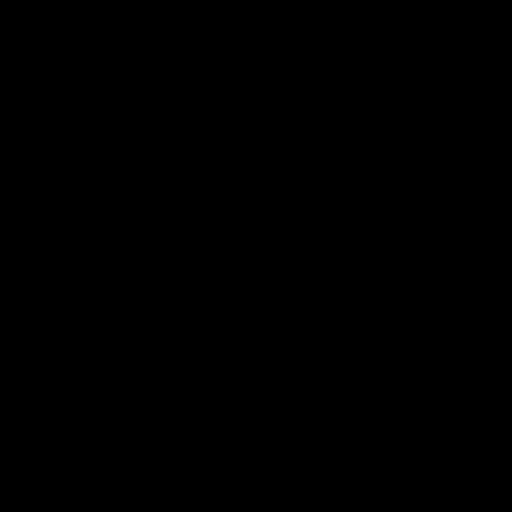

In [60]:
#@title predict with onnx model
image_url = "https://huggingface.co/Carve/LaMa-ONNX/resolve/main/image.jpg" # @param {type:"string"}
mask_url = "https://huggingface.co/Carve/LaMa-ONNX/resolve/main/mask.png" # @param {type:"string"}

image = open_image(image_url).resize((512, 512))
mask = open_image(mask_url).convert("L").resize((512, 512))

image, mask = prepare_img_and_mask(image, mask, 'cpu')
# Run the model
outputs = model.run(None,
                    {'image': image.numpy().astype(np.float32),
                     'mask': mask.numpy().astype(np.float32)})

output = outputs[0][0]
# Postprocess the outputs
output = output.transpose(1, 2, 0)
output = output.astype(np.uint8)
output = Image.fromarray(output)
output